# Generate final LLM DVs per tasl

Starting point:
- dataset with itemlevel values for each task for each model

Goal:
- calculate the final DVs (orient at how Frey caculated the DVs from the item values of the participants)

In [92]:
# packages and data

import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from utils import load_dataframes
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns
import ast


# load overall df
all_data = pd.read_csv("processed_data/items_per_LLM.csv")

### AUDIT SCALE

In [93]:
# extract AUDIT experiment, and sum up score overall
AUDIT_SUB= all_data[all_data["experiment"] == "AUDIT scale"]
AUDIT_DV_DF = AUDIT_SUB.groupby(["model"])["score"].sum().reset_index()

# extract item 1 and if any model scored 0 (not possible, but theoretically correct)
item1 = AUDIT_SUB[AUDIT_SUB["item"] == "1"][["model", "score"]]
item1 = item1.rename(columns={"score": "item1_score"})
AUDIT_DV_DF = AUDIT_DV_DF.merge(item1, on="model")

# if any model scored 0, 0 stays, else add 1 and compute the log, that is the DV of AUDIT (as described in Frey)
AUDIT_DV_DF["score"] = np.where(
    AUDIT_DV_DF["item1_score"] == 0,
    0,
    np.log(AUDIT_DV_DF["score"] + 1)
)

# rename column to concat with rest of data
AUDIT_DV_DF = AUDIT_DV_DF.rename(columns={"score": "AUDIT"})


### BARRAT SCALE
- if I understand it correctly (no docu) sum per subscale

In [94]:
BARRAT_SUB= all_data[all_data["experiment"] == "BARRAT scale"]
BARRAT_DV_DF = BARRAT_SUB.groupby(["model", "category"])["score"].sum().reset_index()
BARRAT_DV_DF = BARRAT_DV_DF.pivot(index="model", columns="category", values="score")


In [95]:
# add_new_df
DV_data = pd.merge(AUDIT_DV_DF[["model", "AUDIT"]], 
                    BARRAT_DV_DF, 
                    on="model",
                    how = "outer")


### CARE SCALE

- binned factors, sum up each category and see in which level (in level_stats) it falls 

In [96]:
CARE_SUB= all_data[all_data["experiment"] == "CARE scale"]
CARE_DV_DF = CARE_SUB.groupby(["model", "category"])["score"].sum().reset_index()
# recode according to defined categories (Frey et al)
def recode_care(row):
    if row['category'] == 'CAREw':  # carework
        if 0 <= row['score'] < 3:
            return 0
        elif 3 <= row['score'] < 8:
            return 1
        elif 8 <= row['score'] < 17:
            return 2
        else:  # 17 and above
            return 3
    elif row['category'] == 'CAREa':  # careaggr
        if row['score'] == 0:
            return 0
        elif 1 <= row['score'] < 5:
            return 1
        else:  # 5 and above
            return 2
    elif row['category'] == 'CAREs':  # caresex
        if 0 <= row['score'] < 2:
            return 0
        elif 2 <= row['score'] < 8:
            return 1
        else:  # 8 and above
            return 2
        
CARE_DV_DF['score'] = CARE_DV_DF.apply(recode_care, axis=1)

# pivot longer for final form 
CARE_DV_DF = CARE_DV_DF.pivot(index="model", columns="category", values="score")


In [97]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    CARE_DV_DF,
    on="model",
    how="outer"
)

### DAST SCALE
- It should be a binned factor:
0 = 0,
1 = 1-18

But when I do that, no discrimination/variation at all, therefore leave it out for now and ask Dirk

In [98]:
DAST_SUB= all_data[all_data["experiment"] == "DAST scale"]
DAST_DV_DF = DAST_SUB.groupby(["model"])["score"].sum().reset_index()


In [99]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DAST_DV_DF[["model", "score"]].rename(columns={"score": "DAST"}),
    on="model",
    how="outer"
)

### DM SCALE
- sum was computed from the following values in each item: 0=never, 1=once or twice, 2=several times, 0=not applicable (mapping done in postprocessing)
- LLM probabilities were already weighed with these values, therefore we can simply sum up

In [100]:
DM_SUB= all_data[all_data["experiment"] == "Dm scale"]
DM_DV_DF = DM_SUB.groupby(["model"])["score"].sum().reset_index() 


In [101]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DM_DV_DF[["model", "score"]].rename(columns={"score": "DM"}),
    on="model",
    how="outer"
)

### DOSPERT SCALE
- if I understand it correctly (no docu) mean per subscale

In [102]:
DOSPERT_SUB= all_data[all_data["experiment"] == "DOSPERT scale"]
DOSPERT_DV_DF = DOSPERT_SUB.groupby(["model", "category"])["score"].mean().reset_index()
DOSPERT_DV_DF = DOSPERT_DV_DF.pivot(index="model", columns="category", values="score")


# rename column to concat with rest of data
DOSPERT_DV_DF = DOSPERT_DV_DF.rename(columns={
    "Ethical": "Deth",
    "Gambling": "Dgam",
    "Health": "Dhea",
    "Investment": "Dinv",
    "Recreational": "Drec",
    "Social": "Dsoc",

    })



In [103]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DOSPERT_DV_DF,
    on="model",
    how="outer"
)

### FTND SCALE
- binned factor of sum score (I think)
- same issue as with DAST, since level 0 and 1 are seperated from 0 to 1 till end, would be no discrimination, leaving as is

In [104]:
FTND_SUB= all_data[all_data["experiment"] == "FTND scale"]
FTND_DV_DF = FTND_SUB.groupby(["model"])["score"].sum().reset_index()


In [105]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    FTND_DV_DF[["model", "score"]].rename(columns={"score": "FTND"}),
    on="model",
    how="outer"
)

### GABS SCALE
- binned factor of sum score (think again)
- weird: in Frey et al, they divide into dfactors: 0 = up to 15, 1 = 15 to 60
- they probably do some form of refactoring of the item 2-16 (since they are going from 1-5or so) (because summing up while using different scales, weird)
- also leaving as is for now

In [106]:
GABS_SUB= all_data[all_data["experiment"] == "GABS scale"]
GABS_DV_DF = GABS_SUB.groupby(["model"])["score"].sum().reset_index()


In [107]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    GABS_DV_DF[["model", "score"]].rename(columns={"score": "GABS"}),
    on="model",
    how="outer"
)

### PG SCALE
- again binned factor of sum score
- but because the levels are 0=0, 1=1-36, would not make sense here

In [108]:
PG_SUB= all_data[all_data["experiment"] == "PG scale"]
PG_DV_DF = PG_SUB.groupby(["model"])["score"].sum().reset_index()


In [109]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    PG_DV_DF[["model", "score"]].rename(columns={"score": "PG"}),
    on="model",
    how="outer"
)

### PRI SCALE
- no docu, nothing, I have NO IDEA how to get to a sensible score in that task
- using sum for now

In [110]:
PRI_SUB= all_data[all_data["experiment"] == "PRI scale"]
PRI_DV_DF = PRI_SUB.groupby(["model", "category"])["score"].sum().reset_index()
PRI_DV_DF = PRI_DV_DF.pivot(index="model", columns="category", values="score")


# rename column to concat with rest of data
PRI_DV_DF = PRI_DV_DF.rename(columns={
    "certainty": "PRI_certainty",
    "decision": "PRI_decision",

    })

In [111]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    PRI_DV_DF,
    on="model",
    how="outer"
)

### SOEP SCALE

- simply stays the same, every value in one sub category is one value

In [112]:
SOEP_SUB= all_data[all_data["experiment"] == "SOEP scale"]
SOEP_DV_DF = SOEP_SUB.pivot(index="model", columns="category", values="score")

In [113]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    SOEP_DV_DF,
    on="model",
    how="outer"
)

### SSSV SCALE

- I guess summing over sub categories?!

In [114]:
SSSV_SUB= all_data[all_data["experiment"] == "SSSV scale"]
SSSV_DV_DF = SSSV_SUB.groupby(["model", "category"])["score"].sum().reset_index()
SSSV_DV_DF = SSSV_DV_DF.pivot(index="model", columns="category", values="score")


In [115]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    SSSV_DV_DF,
    on="model",
    how="outer"
)

### BART TASK

- mean number of pumps over trials (items)

In [116]:
BART_SUB= all_data[all_data["experiment"] == "BART task"]
BART_DV_DF = BART_SUB.groupby(["model"])["score"].mean().reset_index()
#BART_DV_DF

In [117]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    BART_DV_DF[["model", "score"]].rename(columns={"score": "BART"}),
    on="model",
    how="outer"
)

### CCT TASK
- sum of all cards drawn (scores of all items per person summed up)

In [118]:
CCT_SUB= all_data[all_data["experiment"] == "CCT task"]
CCT_DV_DF = CCT_SUB.groupby(["model"])["score"].sum().reset_index()
#CCT_DV_DF

In [119]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    CCT_DV_DF[["model", "score"]].rename(columns={"score": "CCT"}),
    on="model",
    how="outer"
)

### DFD TASK

- DFD is the proportion of risky choices out of all choices
- i.e. sum(choices)/len(choices), mean
- in human samples, the item answers would all be "0" or "1", but since we already weighed with all human answers, we already have decimal numbers between 0 and 1, indicating more fine-grained answers per item already

In [120]:
DFD_SUB= all_data[all_data["experiment"] == "DFD task"]
DFD_DV_DF = DFD_SUB.groupby(["model"])["score"].mean().reset_index()
#DFD_DV_DF

In [121]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DFD_DV_DF[["model", "score"]].rename(columns={"score": "DFD"}),
    on="model",
    how="outer"
)

### DFE TASK
- same as DFD
- DFE re is the proportion of risky choices out of all choices
- i.e. sum(choices)/len(choices), mean
- in human samples, the item answers would all be "0" or "1", but since we already weighed with all human answers, we already have decimal numbers between 0 and 1, indicating more fine-grained answers per item already

In [122]:
DFE_SUB= all_data[all_data["experiment"] == "DFE task"]
DFE_DV_DF = DFE_SUB.groupby(["model"])["score"].mean().reset_index()
#DFE_DV_DF

In [123]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DFE_DV_DF[["model", "score"]].rename(columns={"score": "DFE"}),
    on="model",
    how="outer"
)

### LOT TASK

- mean i.e. proportion of risky choices out of the 25 trials.

In [124]:
LOT_SUB= all_data[all_data["experiment"] == "LOT task"]
LOT_DV_DF = LOT_SUB.groupby(["model"])["score"].mean().reset_index()
#LOT_DV_DF

In [125]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    LOT_DV_DF[["model", "score"]].rename(columns={"score": "LOT"}),
    on="model",
    how="outer"
)

### MPL TASK
- switching point:
    - only the first of all rounds is taken into consideration
    - there it is looked at the switching point (the first decision for the riskier choice)

- I will also only consider the first round, look at the scores and round probabilities under 0.5 to 0 and from 0.5 on to 1. 
- then I will define the switching point of a model as the first 1 decision. (=DV)

In [126]:
# filter only MPL data and filter only data for the first round, (since round 2-7 are ignored for the DV)
MPL_SUB= all_data[all_data["experiment"] == "MPL task"]
MPL_SUB['item'] = MPL_SUB['item'].apply(ast.literal_eval)
MPL_SUB_ROUND_1 = MPL_SUB[MPL_SUB['item'].apply(lambda x: x[0] == 1)]


/var/folders/g6/6tx7kz_51_92m63qx0q2c2lw0000gn/T/ipykernel_6308/2303537433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MPL_SUB['item'] = MPL_SUB['item'].apply(ast.literal_eval)


In [127]:
# define the switching point by first transforming all scores to 0 or 1 (depends on whether they are bigger than 0.5)
MPL_SUB_ROUND_1["decision"] = np.where(
    MPL_SUB_ROUND_1["score"] <= 0.5,
    0,
    1
)

#MPL_SUB_ROUND_1.tail(50)

/var/folders/g6/6tx7kz_51_92m63qx0q2c2lw0000gn/T/ipykernel_6308/1789067762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MPL_SUB_ROUND_1["decision"] = np.where(


In [128]:
# not yet happy with, current sum up technique to simulate switching point
MPL_DV_DF = MPL_SUB_ROUND_1.groupby(["model"])["decision"].sum().reset_index()
#MPL_DV_DF

In [129]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    MPL_DV_DF[["model", "decision"]].rename(columns={"decision": "MPL"}),
    on="model",
    how="outer"
)

## Preliminary Results

In [130]:
DV_data.to_csv('processed_data/final_DVs.csv', index=False)

In [131]:
DV_data.columns

Index(['model', 'AUDIT', 'BISa', 'BISm', 'BISn', 'CAREa', 'CAREs', 'CAREw',
       'DAST', 'DM', 'Deth', 'Dgam', 'Dhea', 'Dinv', 'Drec', 'Dsoc', 'FTND',
       'GABS', 'PG', 'PRI_certainty', 'PRI_decision', 'SOEP', 'SOEPdri',
       'SOEPfin', 'SOEPhea', 'SOEPocc', 'SOEPrec', 'SOEPsoc', 'SSbor', 'SSdis',
       'SSexp', 'SStas', 'BART', 'CCT', 'DFD', 'DFE', 'LOT', 'MPL'],
      dtype='object')

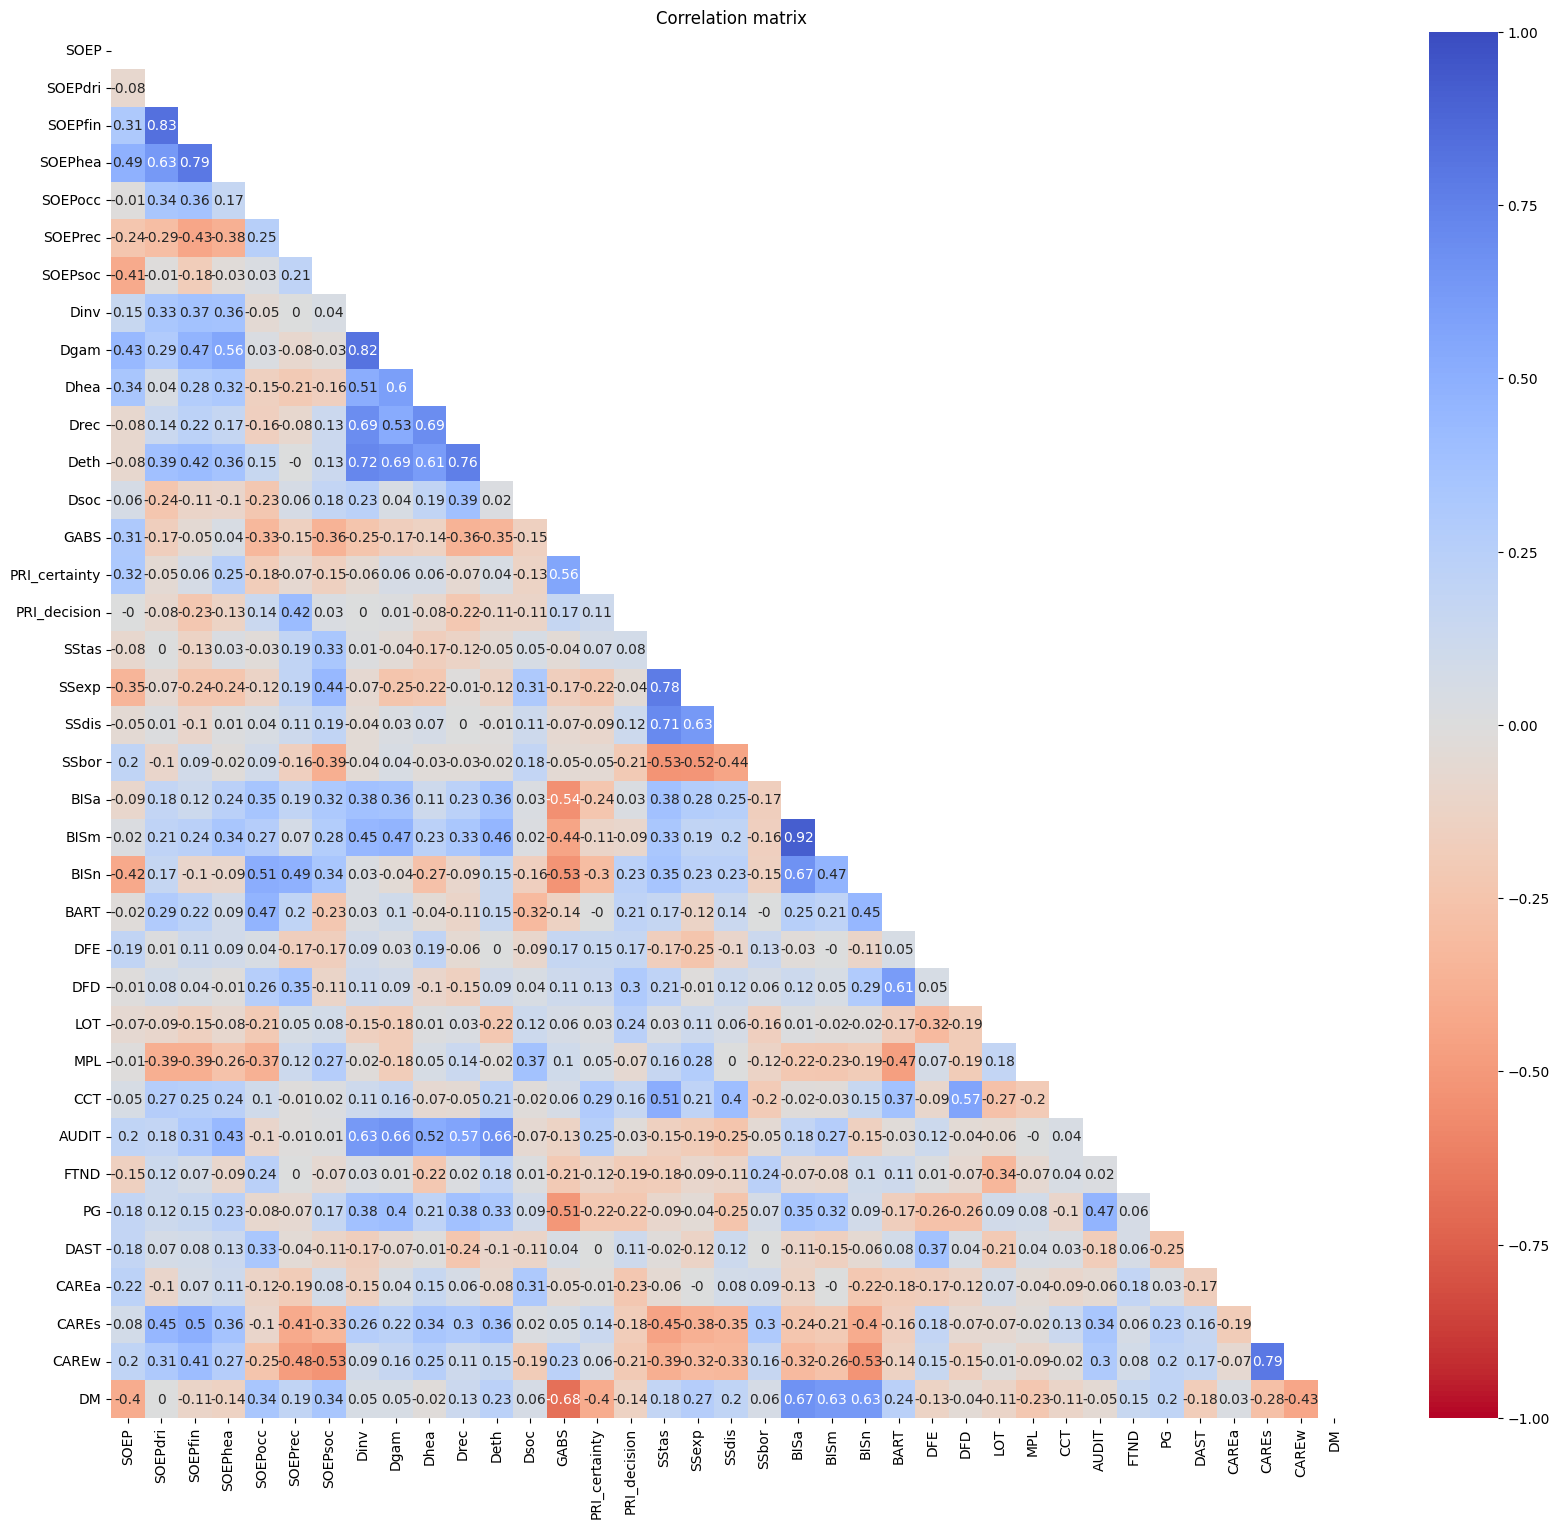

In [132]:
# Compute correlation matrix (only for numeric columns)
numeric_df = DV_data.drop(columns=['model'])
corr = numeric_df.corr().round(2)

# reorder to compare with human data
order = ['SOEP', 'SOEPdri', 'SOEPfin', 'SOEPhea', 'SOEPocc', 'SOEPrec', 'SOEPsoc',
        'Dinv', 'Dgam', 'Dhea', 'Drec', 'Deth', 'Dsoc', 'GABS', 'PRI_certainty', 'PRI_decision', 
        'SStas', 'SSexp', 'SSdis', 'SSbor', 'BISa', 'BISm', 'BISn', 'BART', 'DFE', 'DFD', 'LOT', 'MPL', 'CCT', 
         'AUDIT', 'FTND', 'PG', 'DAST', 'CAREa', 'CAREs', 'CAREw', 'DM']  

corr_reordered = corr.loc[order, order].round(2)

# Display it as a heatmap
# plt.figure(figsize=(20, 18))
# sns.heatmap(corr, annot=True, cmap="coolwarm_r", vmin=-1, vmax=1)
# plt.title("Correlation matrix of model scores")
# plt.show()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_reordered, dtype=bool))

# Plot heatmap with mask
plt.figure(figsize=(20, 18))
sns.heatmap(
    corr_reordered,
    mask=mask,
    annot=True,
    cmap="coolwarm_r",
    vmin=-1,
    vmax=1
)
plt.title("Correlation matrix")
plt.show()


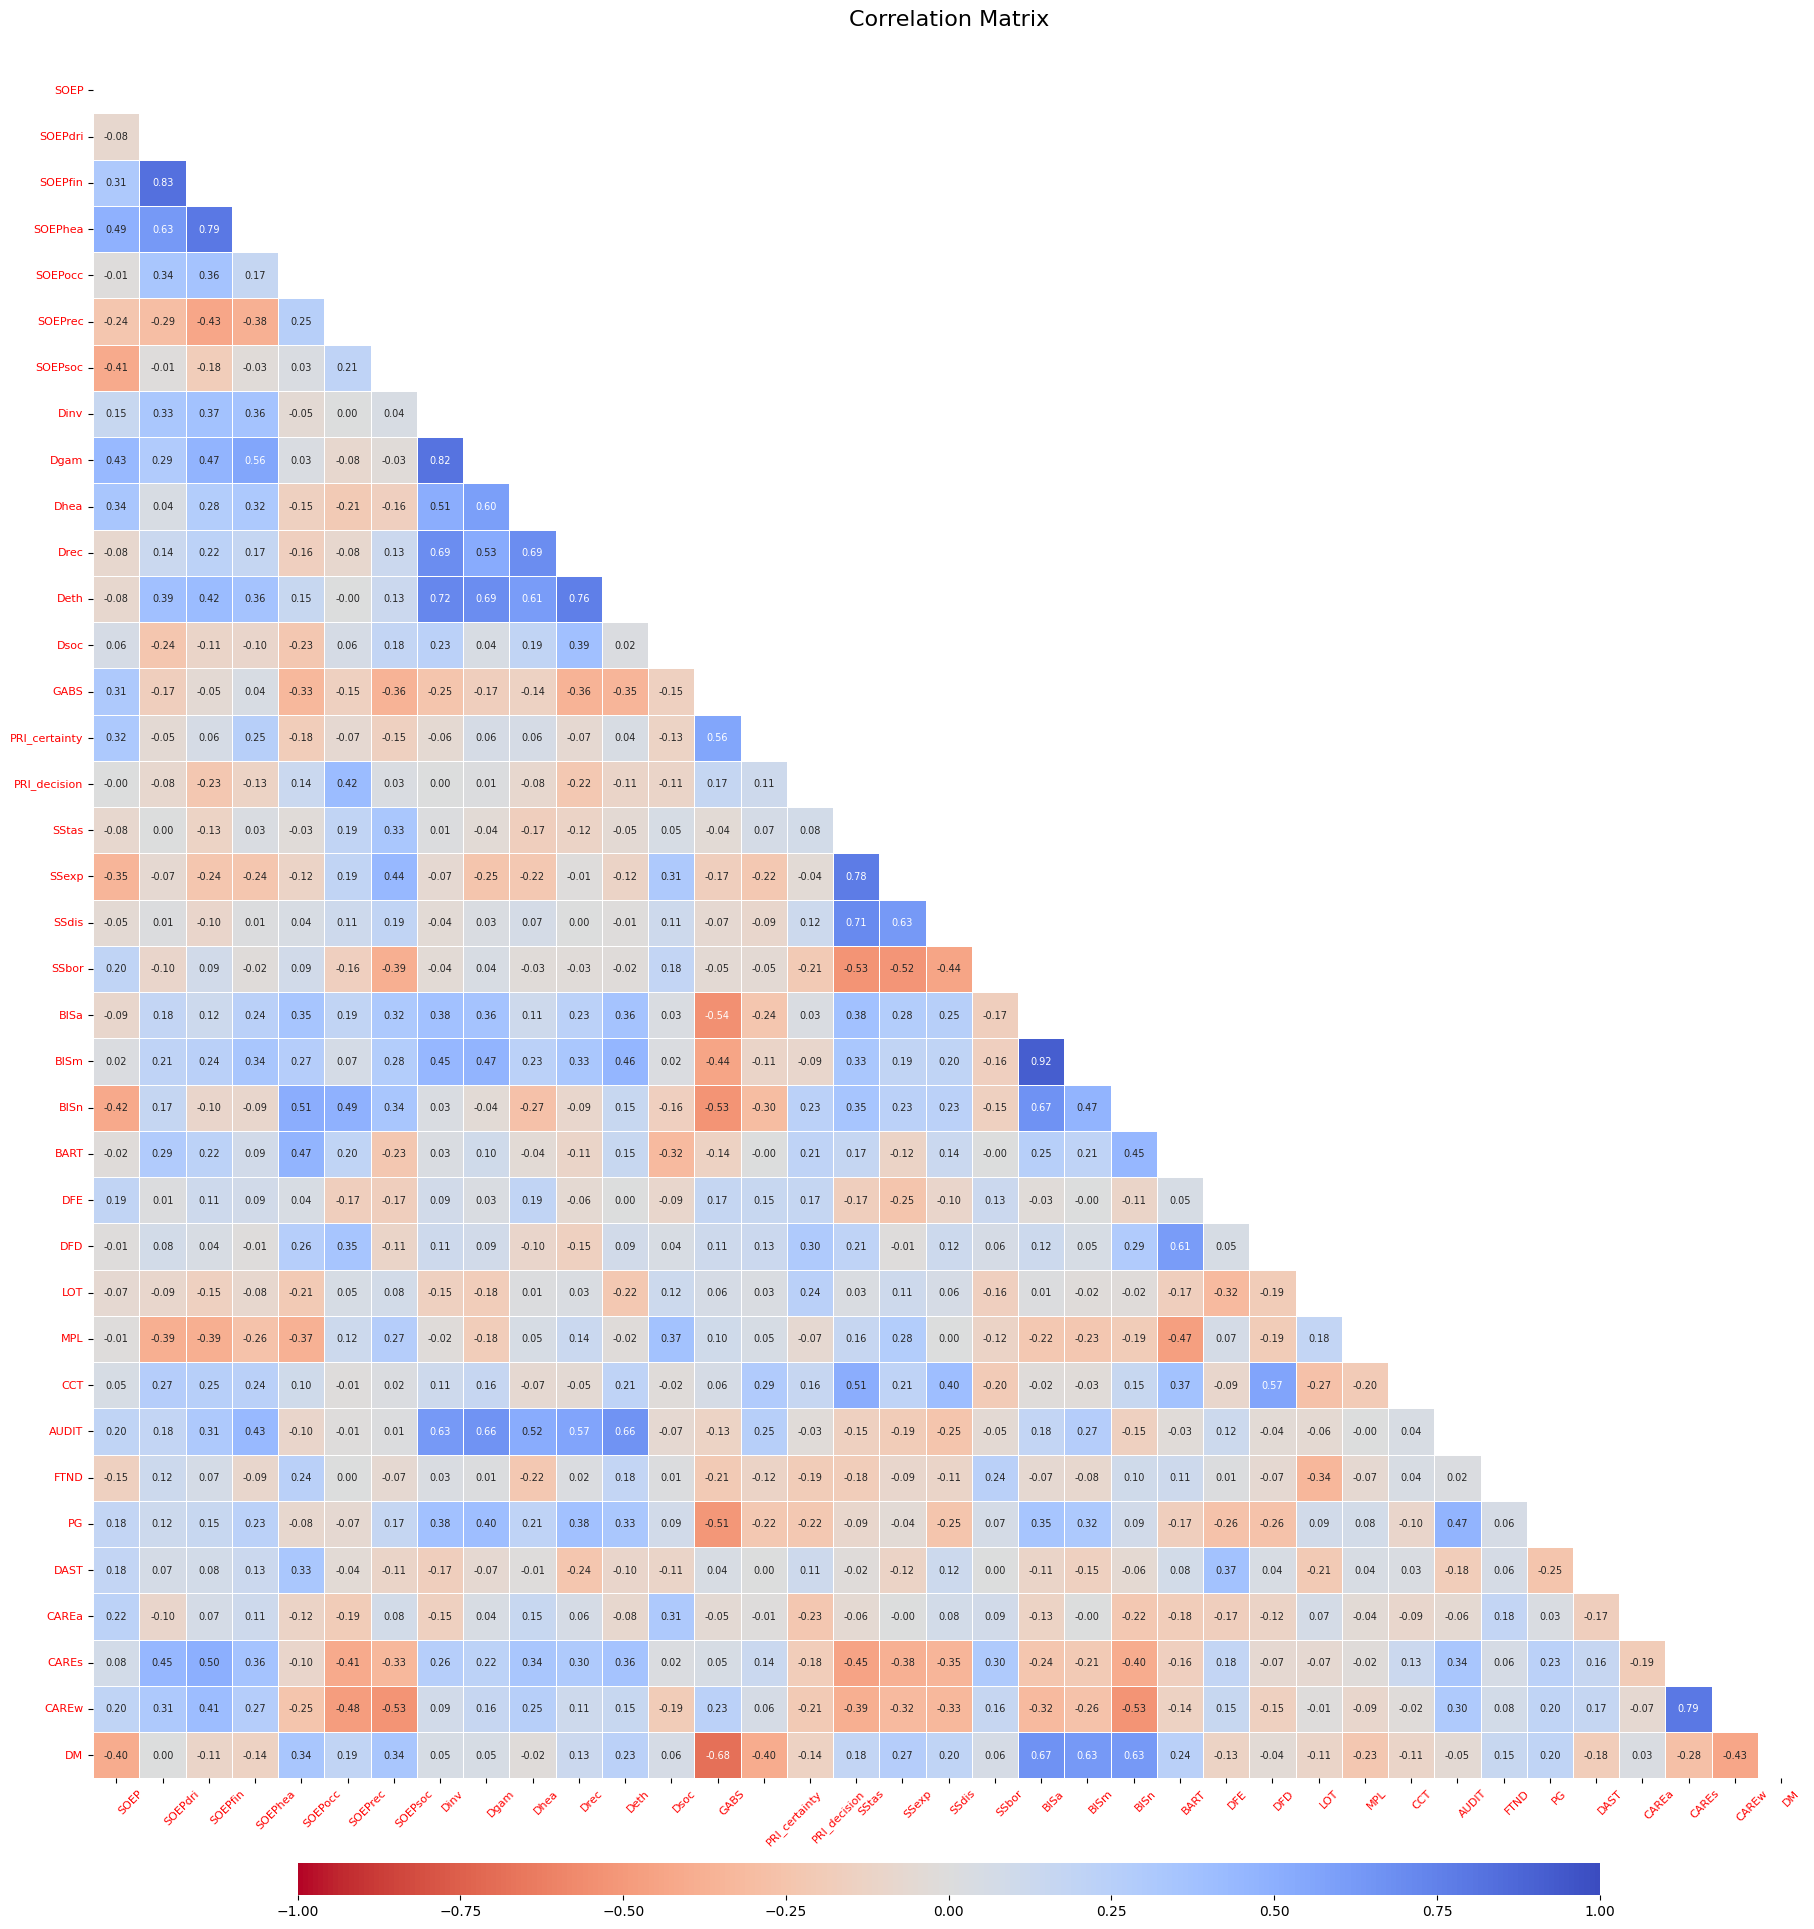

In [133]:
#plot corr matrix style Frey et al. (2017)

plt.figure(figsize=(22, 22))

# mask upper triangle (keep lower triangle)
mask = np.triu(np.ones_like(corr_reordered, dtype=bool))

# heatmap with horizontal (bottom) colorbar; small pad so it sits close
ax = sns.heatmap(
    corr_reordered,
    mask=mask,
    annot=True,
    fmt=".2f",
    annot_kws={"fontsize":7, "va":"center", "ha":"center"},  # center numbers in cells
    cmap="coolwarm_r",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.4,
    linecolor="white",
    cbar_kws={
        "orientation":"horizontal",
        "pad":0.04,      # distance between heatmap and colorbar
        "shrink":0.6,
        "aspect":40
    }
)

# move x labels to the top
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('bottom')

# tighten tick padding so labels sit closer to the heatmap
# ax.tick_params(axis='x', which='both', pad=2)
# ax.tick_params(axis='y', which='both', pad=2)

# rotate & align x tick labels and reduce font size
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left", fontsize=8)

# y labels: no rotation, small font
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

# color both x and y tick labels red
for lbl in ax.get_xticklabels():
    lbl.set_color("red")
for lbl in ax.get_yticklabels():
    lbl.set_color("red")

plt.title("Correlation Matrix", fontsize=16, pad=30)
plt.tight_layout()
plt.show()

